In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import pymatgen

from functions.prepare_data_and_sub import prepare_dataset, make_prediction, energy_within_threshold
from functions.class2_features import unufication_class2, geometrical_features, distance_features
from functions.classification import classificate_class2, classificate_class3, classificate_class4, classificate_class5
from functions.classification import convert_group_to_target_class2, convert_group_to_target_class3, convert_group_to_target_class4, convert_group_to_target_class5
from functions.strusture_analysis import decompose, make_masks, find_differ_sites, extract_ideal_structure

In [2]:
data = prepare_dataset('data/dichalcogenides_public/')
data['decomposition'] = data.structures.apply(decompose)
mask_list = make_masks(data)
ideal_structure_sites = extract_ideal_structure(data)  
data['representative'] = data['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))

  0%|          | 0/380 [00:00<?, ?it/s]

In [3]:
test = prepare_dataset('data/dichalcogenides_private/', train=False)
test['decomposition'] = test.structures.apply(decompose)
mask_list_test = make_masks(test)
test['representative'] = test['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))

test = make_prediction(test, ideal_structure_sites, mask_list_test)

### Class2:

In [59]:
model = DecisionTreeClassifier(max_depth=15, random_state=13)

class2 = data[mask_list[2]].copy()
class2['group'] = class2['targets'].apply(classificate_class2)

class2 = unufication_class2(class2)
class2 = geometrical_features(class2)

test_class2 = unufication_class2(test[mask_list_test[2]])
test_class2 = geometrical_features(test_class2)

feature_list = ['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']
model.fit(class2[feature_list], class2['group'])

class2_predict_group3 = model.predict(test_class2[feature_list])

/home/polli/IDAO-2022/functions/class2_features.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['representative'] = sample['representative'].apply(lambda x: symmetry_transform_up(x.copy(), x[0].coords))
/home/polli/IDAO-2022/functions/class2_features.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['representative'] = sample['representative'].apply(lambda x: orange_closer(x.copy()))
/home/polli/IDAO-2022/functions/class2_features.py:11: SettingWithCopyWarning: 
A value is trying to be s

In [5]:
class2 = class2[(class2.group == 2) | (class2.group == 1)]

In [6]:
from xgboost import XGBClassifier

feature_list = list(class2.columns[5:])

model = XGBClassifier(n_estimators=45, random_state=0xC0FFEE)
model.fit(class2[feature_list], class2['group'])
class2_predict_group12 = model.predict(test_class2[feature_list])


/home/polli/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
class2_predict_group = class2_predict_group12
class2_predict_group[class2_predict_group3 == 3] = 3

predictions_class2 = list(map(convert_group_to_target_class2, class2_predict_group))
test.loc[mask_list_test[2], 'predictions'] = predictions_class2

### Class3:

In [57]:
class3 = data[mask_list[3]].copy()
class3['group'] = class3['targets'].apply(classificate_class3)
class3 = class3[class3.group != 0]
class3 = distance_features(class3)

test_class3 = test[mask_list_test[3]].copy()
test_class3 = distance_features(test_class3)

for i in range(3):
    class3['dist' + str(i+1)] = class3[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class3['dist' + str(i+1)] = test_class3[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
model = XGBClassifier(n_estimators=30, random_state=0xC0FFEE)
model.fit(class3[feature_list], class3['group'])

class3_predict_group = model.predict(test_class3[feature_list])

[17:21:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[17:21:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8512396694214877


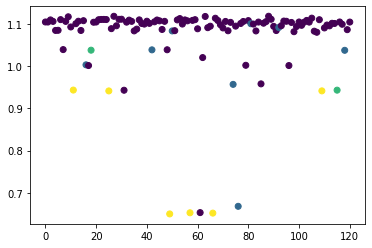

In [58]:
X_train, X_test, y_train, y_test = train_test_split(class3, class3['group'], test_size=0.33, random_state=42)

model = XGBClassifier(n_estimators=10, random_state=0xC0FFEE)

model.fit(X_train[feature_list], y_train)
class3_predict_group = model.predict(X_test[feature_list])

print(np.sum(class3_predict_group == y_test) / len(y_test))
plt.scatter(np.arange(len(y_test)), X_test.targets, c=class3_predict_group)
plt.show()

In [9]:
predictions_class3 = list(map(convert_group_to_target_class3, class3_predict_group))
test.loc[mask_list_test[3], 'predictions'] = predictions_class3

### Class4

In [25]:
class4 = data[mask_list[4]].copy()
class4['group'] = class4['targets'].apply(classificate_class4)
class4 = class4[class4.group != 0]
class4 = distance_features(class4)

test_class4 = test[mask_list_test[4]].copy()
test_class4 = distance_features(test_class4)

for i in range(3):
    class4['dist' + str(i+1)] = class4[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class4['dist' + str(i+1)] = test_class4[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
# model = XGBClassifier(n_estimators=30, random_state=0xC0FFEE)
# model.fit(class4[feature_list], class4['group'])

# class4_predict_group = model.predict(test_class4[feature_list])

In [26]:
class4['group'].value_counts()

2    226
1     81
3     31
Name: group, dtype: int64

[17:19:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9285714285714286


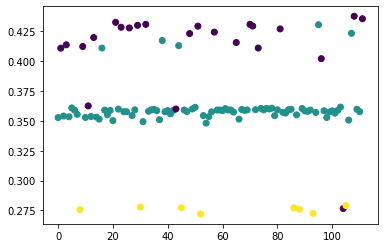

In [38]:
X_train, X_test, y_train, y_test = train_test_split(class4, class4['group'], test_size=0.33, random_state=42)

model = XGBClassifier(n_estimators=5, random_state=0xC0FFEE)

model.fit(X_train[feature_list], y_train)
class4_predict_group = model.predict(X_test[feature_list])

print(np.sum(class4_predict_group == y_test) / len(y_test))
plt.scatter(np.arange(len(y_test)), X_test.targets, c=class4_predict_group)
plt.show()

### Class5

In [66]:
class5 = data[mask_list[5]].copy()
class5['group'] = class5['targets'].apply(classificate_class5)
class5 = class5[class5.group != 0]
class5 = distance_features(class5)

test_class5 = test[mask_list_test[5]].copy()
test_class5 = distance_features(test_class5)

for i in range(3):
    class5['dist' + str(i+1)] = class5[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class5['dist' + str(i+1)] = test_class5[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
model = XGBClassifier(n_estimators=5, random_state=0xC0FFEE)
model.fit(class5[feature_list], class5['group'])

class5_predict_group = model.predict(test_class5[feature_list])

[17:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/polli/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [67]:
class5.group.value_counts() / len(class5)

1    0.596774
2    0.248387
3    0.154839
Name: group, dtype: float64

In [70]:
class5

,structures,targets,decomposition,representative,group,dist_to_diag_Mo,dist_to_diag_S,dist_to_diag_Se,Mo_S_dist,S_Se_dist,Mo_Se_dist,dist1,dist2,dist3
6141cf303ac25c70a5c6c84d,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4227,"{'Mo1': 63, 'S1': 126}","[[15.95157863 12.89350732 3.719751 ] Mo, [14...",1,6.380724,4.785448,0.000006,3.489884,3.866665,3.363447,3.363447,3.489884,3.866665
6143f8083ac25c70a5c6cd4b,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4162,"{'Mo1': 63, 'S1': 126}","[[19.14189433 1.84192955 3.719751 ] Mo, [9....",1,1.595037,4.785456,4.785464,3.141878,2.520028,3.893307,2.520028,3.141878,3.893307
61434b773ac25c70a5c6ccd9,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3000,"{'Mo1': 63, 'S1': 126}","[[19.14189433 1.84192955 3.719751 ] Mo, [19...",3,1.595037,0.000030,7.975771,1.554642,3.452682,3.363447,1.554642,3.363447,3.452682
6141d01d3ac25c70a5c6c883,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4083,"{'Mo1': 63, 'S1': 126}","[[7.97578938 4.604824 3.719751 ] Mo, [ 4.78...",1,4.785390,4.785475,3.190294,3.657076,3.993943,2.262381,2.262381,3.657076,3.993943
61421e623ac25c70a5c6cacd,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4251,"{'Mo1': 63, 'S1': 126}","[[ 7.97578938 10.13061288 3.719751 ] Mo, [-3...",1,0.000074,6.380634,1.595124,3.363447,5.032131,3.976816,3.363447,3.976816,5.032131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142e26f3ac25c70a5c6cc67,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3562,"{'Mo1': 63, 'S1': 126}","[[-3.19031557 18.41929621 3.719751 ] Mo, [ 9...",2,1.595184,4.785483,1.595168,3.657076,2.114032,3.603904,2.114032,3.603904,3.657076
6142e6093ac25c70a5c6cc69,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3588,"{'Mo1': 63, 'S1': 126}","[[ 4.78547368 10.13061288 3.719751 ] Mo, [-4...",2,1.595093,0.000010,4.785475,3.489884,3.093695,2.744461,2.744461,3.093695,3.489884
614298fb3ac25c70a5c6cc0d,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.4170,"{'Mo1': 63, 'S1': 126}","[[ 4.78547368 10.13061288 3.719751 ] Mo, [ 1...",1,1.595093,3.190313,7.975791,2.860046,2.350700,3.220890,2.350700,2.860046,3.220890
6142e1d73ac25c70a5c6cc65,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.3042,"{'Mo1': 63, 'S1': 126}","[[3.19031583 1.84192955 3.719751 ] Mo, [6.380...",3,9.570873,6.380618,6.380629,2.000611,4.108718,4.299494,2.000611,4.108718,4.299494


In [68]:
X_train[feature_list]

,dist1,dist2,dist3
6141d53c3ac25c70a5c6c8f7,1.554642,5.011282,5.082760
6143a3fb3ac25c70a5c6cd1f,1.786145,3.363447,3.804049
6141de393ac25c70a5c6c967,2.520028,3.141878,3.220890
6141fe673ac25c70a5c6ca4d,3.141878,3.729110,4.666084
614499e33ac25c70a5c6cd87,2.860046,3.173273,4.200052
...,...,...,...
6143a4a73ac25c70a5c6cd21,2.262381,2.520028,3.141878
6141d0bf3ac25c70a5c6c899,3.657076,4.200052,5.325049
614318743ac25c70a5c6cca3,2.520028,3.657076,4.331158
6141e72c3ac25c70a5c6c9b7,2.905302,4.200052,4.535468


# Почему-то ячейка ниже давала разный результат в двух ноутбуках

[17:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7184466019417476


/home/polli/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


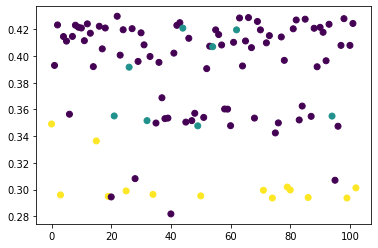

In [69]:
X_train, X_test, y_train, y_test = train_test_split(class5, class5['group'], test_size=0.33, random_state=42)

model = XGBClassifier(n_estimators=10, random_state=0xC0FFEE)

model.fit(X_train[feature_list], y_train)
class4_predict_group = model.predict(X_test[feature_list])

print(np.sum(class4_predict_group == y_test) / len(y_test))
plt.scatter(np.arange(len(y_test)), X_test.targets, c=class4_predict_group)
plt.show()

## Submission